In [1]:
import keras
import keras.backend as K
from keras.datasets import mnist
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Dropout, Activation, Flatten, Input, Lambda
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, Conv1D, MaxPooling1D, LSTM, ConvLSTM2D, GRU, BatchNormalization, LocallyConnected2D, Permute, TimeDistributed, Bidirectional
from keras.layers import Concatenate, Reshape, Conv2DTranspose, Embedding, Multiply, Activation

from functools import partial

from collections import defaultdict

import os
import pickle
import numpy as np

import scipy.sparse as sp
import scipy.io as spio

import isolearn.io as isoio
import isolearn.keras as isol

import matplotlib.pyplot as plt

from sequence_logo_helper import dna_letter_at, plot_dna_logo

import tensorflow as tf

from keras.backend.tensorflow_backend import set_session

def contain_tf_gpu_mem_usage() :
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    sess = tf.Session(config=config)
    set_session(sess)

contain_tf_gpu_mem_usage()


Using TensorFlow backend.


In [2]:
#Define dataset/experiment name
dataset_name = "apa_doubledope"

#Load cached dataframe
cached_dict = pickle.load(open('apa_doubledope_cached_set.pickle', 'rb'))
data_df = cached_dict['data_df']

print("len(data_df) = " + str(len(data_df)) + " (loaded)")


len(data_df) = 34748 (loaded)


In [3]:
#Make generators

valid_set_size = 0.05
test_set_size = 0.05

batch_size = 32

#Generate training and test set indexes
data_index = np.arange(len(data_df), dtype=np.int)

train_index = data_index[:-int(len(data_df) * (valid_set_size + test_set_size))]
valid_index = data_index[train_index.shape[0]:-int(len(data_df) * test_set_size)]
test_index = data_index[train_index.shape[0] + valid_index.shape[0]:]

print('Training set size = ' + str(train_index.shape[0]))
print('Validation set size = ' + str(valid_index.shape[0]))
print('Test set size = ' + str(test_index.shape[0]))


data_gens = {
    gen_id : isol.DataGenerator(
        idx,
        {'df' : data_df},
        batch_size=batch_size,
        inputs = [
            {
                'id' : 'seq',
                'source_type' : 'dataframe',
                'source' : 'df',
                'extractor' : isol.SequenceExtractor('padded_seq', start_pos=180, end_pos=180 + 205),
                'encoder' : isol.OneHotEncoder(seq_length=205),
                'dim' : (1, 205, 4),
                'sparsify' : False
            }
        ],
        outputs = [
            {
                'id' : 'hairpin',
                'source_type' : 'dataframe',
                'source' : 'df',
                'extractor' : lambda row, index: row['proximal_usage'],
                'transformer' : lambda t: t,
                'dim' : (1,),
                'sparsify' : False
            }
        ],
        randomizers = [],
        shuffle = True if gen_id == 'train' else False
    ) for gen_id, idx in [('all', data_index), ('train', train_index), ('valid', valid_index), ('test', test_index)]
}


Training set size = 31274
Validation set size = 1737
Test set size = 1737


In [4]:
#Load data matrices

x_train = np.concatenate([data_gens['train'][i][0][0] for i in range(len(data_gens['train']))], axis=0)
x_test = np.concatenate([data_gens['test'][i][0][0] for i in range(len(data_gens['test']))], axis=0)

y_train = np.concatenate([data_gens['train'][i][1][0] for i in range(len(data_gens['train']))], axis=0)
y_test = np.concatenate([data_gens['test'][i][1][0] for i in range(len(data_gens['test']))], axis=0)

print("x_train.shape = " + str(x_train.shape))
print("x_test.shape = " + str(x_test.shape))

print("y_train.shape = " + str(y_train.shape))
print("y_test.shape = " + str(y_test.shape))


x_train.shape = (31264, 1, 205, 4)
x_test.shape = (1728, 1, 205, 4)
y_train.shape = (31264, 1)
y_test.shape = (1728, 1)


In [5]:
#Define sequence template (APA Doubledope sublibrary)

sequence_template = 'CTTCCGATCTNNNNNNNNNNNNNNNNNNNNCATTACTCGCATCCANNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNCAGCCAATTAAGCCNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNCTAC'

sequence_mask = np.array([1 if sequence_template[j] == 'N' else 0 for j in range(len(sequence_template))])


In [15]:
#Load predictor model

#APARENT parameters
seq_input_shape = (1, 205, 4)
lib_input_shape = (13,)
distal_pas_shape = (1,)
num_outputs_iso = 1
num_outputs_cut = 206

#Shared model definition
layer_1 = Conv2D(96, (8, 4), padding='valid', activation='relu')
layer_1_pool = MaxPooling2D(pool_size=(2, 1))
layer_2 = Conv2D(128, (6, 1), padding='valid', activation='relu')
layer_dense = Dense(256, activation='relu')
layer_drop = Dropout(0.2)

def shared_model(seq_input, distal_pas_input) :
    return layer_drop(
        layer_dense(
            Concatenate()([
                Flatten()(
                    layer_2(
                        layer_1_pool(
                            layer_1(
                                seq_input
                            )
                        )
                    )
                ),
                distal_pas_input
            ])
        )
    )

#Inputs
seq_input = Input(name="seq_input", shape=seq_input_shape)

permute_layer = Lambda(lambda x: K.permute_dimensions(x, (0, 2, 3, 1)))

lib_input = Lambda(lambda x: K.tile(K.expand_dims(K.constant(np.array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.])), axis=0), (K.shape(x)[0], 1)))(seq_input)
distal_pas_input = Lambda(lambda x: K.tile(K.expand_dims(K.constant(np.array([1.])), axis=0), (K.shape(x)[0], 1)))(seq_input)

plasmid_out_shared = Concatenate()([shared_model(permute_layer(seq_input), distal_pas_input), lib_input])

plasmid_out_cut = Dense(num_outputs_cut, activation='softmax', kernel_initializer='zeros')(plasmid_out_shared)
plasmid_out_iso = Dense(num_outputs_iso, activation='sigmoid', kernel_initializer='zeros')(plasmid_out_shared)

predictor_temp = Model(
    inputs=[
        seq_input
    ],
    outputs=[
        plasmid_out_iso,
        plasmid_out_cut
    ]
)

predictor_temp.load_weights('../../../aparent/saved_models/aparent_plasmid_iso_cut_distalpas_all_libs_no_sampleweights_sgd.h5')

predictor = Model(
    inputs=predictor_temp.inputs,
    outputs=[
        Concatenate(axis=-1)([Lambda(lambda x: 1. - x)(predictor_temp.outputs[0]), predictor_temp.outputs[0]])
    ]
)

predictor.trainable = False

predictor.compile(
    optimizer=keras.optimizers.SGD(lr=0.1),
    loss='mean_squared_error'
)



In [16]:
#Generate (original) predictions

pred_train = predictor.predict(x_train, batch_size=32)
pred_test = predictor.predict(x_test, batch_size=32)


In [18]:
###########################################
####################L2X####################
###########################################

from keras.callbacks import ModelCheckpoint
from keras.models import Model, Sequential 

import numpy as np
import tensorflow as tf

from keras.layers import MaxPooling2D, Flatten, Conv2D, Input, GlobalMaxPooling2D, Multiply, Lambda, Embedding, Dense, Dropout, Activation
from keras.datasets import imdb
from keras import backend as K  
from keras.engine.topology import Layer 

# Define various Keras layers.
class Concatenate1D(Layer):
    """
    Layer for concatenation. 

    """
    def __init__(self, **kwargs): 
        super(Concatenate1D, self).__init__(**kwargs)

    def call(self, inputs):
        input1, input2 = inputs  
        input1 = tf.expand_dims(input1, axis = -2) # [batchsize, 1, input1_dim] 
        dim1 = int(input2.get_shape()[1])
        input1 = tf.tile(input1, [1, dim1, 1])
        return tf.concat([input1, input2], axis = -1)

    def compute_output_shape(self, input_shapes):
        input_shape1, input_shape2 = input_shapes
        input_shape = list(input_shape2)
        input_shape[-1] = int(input_shape[-1]) + int(input_shape1[-1])
        input_shape[-2] = int(input_shape[-2])
        return tuple(input_shape)

class Concatenate2D(Layer):
    """
    Layer for concatenation. 

    """
    def __init__(self, **kwargs): 
        super(Concatenate2D, self).__init__(**kwargs)

    def call(self, inputs):
        input1, input2 = inputs  
        input1 = tf.expand_dims(tf.expand_dims(input1, axis = -2), axis = -2) # [batchsize, 1, 1, input1_dim] 
        dim1 = int(input2.get_shape()[1])
        dim2 = int(input2.get_shape()[2])
        input1 = tf.tile(input1, [1, dim1, dim2, 1])
        return tf.concat([input1, input2], axis = -1)

    def compute_output_shape(self, input_shapes):
        input_shape1, input_shape2 = input_shapes
        input_shape = list(input_shape2)
        input_shape[-1] = int(input_shape[-1]) + int(input_shape1[-1])
        input_shape[-2] = int(input_shape[-2])
        input_shape[-3] = int(input_shape[-3])
        return tuple(input_shape)

class Sample_Concrete(Layer):
    """
    Layer for sample Concrete / Gumbel-Softmax variables. 

    """
    def __init__(self, tau0, k, **kwargs): 
        self.tau0 = tau0
        self.k = k
        super(Sample_Concrete, self).__init__(**kwargs)

    def call(self, logits):   
        # logits: [batch_size, d, 1]
        logits_ = K.permute_dimensions(logits, (0,2,1))# [batch_size, 1, d]
        
        d = int(logits_.get_shape()[2])
        unif_shape = [batch_size,self.k,d]

        uniform = K.random_uniform_variable(shape=unif_shape,
            low = np.finfo(tf.float32.as_numpy_dtype).tiny,
            high = 1.0)
        gumbel = - K.log(-K.log(uniform))
        noisy_logits = (gumbel + logits_)/self.tau0
        samples = K.softmax(noisy_logits)
        samples = K.max(samples, axis = 1) 
        logits = tf.reshape(logits,[-1, d]) 
        threshold = tf.expand_dims(tf.nn.top_k(logits, self.k, sorted = True)[0][:,-1], -1)
        discrete_logits = tf.cast(tf.greater_equal(logits,threshold),tf.float32)

        output = K.in_train_phase(samples, discrete_logits) 
        return tf.expand_dims(output,-1)

    def compute_output_shape(self, input_shape):
        return input_shape

def construct_gumbel_selector(X_ph, n_filters=32, n_dense_units=32):
    """
    Build the L2X model for selection operator. 

    """
    first_layer = Conv2D(n_filters, (1, 7), padding='same', activation='relu', strides=1, name = 'conv1_gumbel')(X_ph)    

    # global info
    net_new = GlobalMaxPooling2D(name = 'new_global_max_pooling1d_1')(first_layer)
    global_info = Dense(n_dense_units, name = 'new_dense_1', activation='relu')(net_new) 

    # local info
    net = Conv2D(n_filters, (1, 7), padding='same', activation='relu', strides=1, name = 'conv2_gumbel')(first_layer) 
    local_info = Conv2D(n_filters, (1, 7), padding='same', activation='relu', strides=1, name = 'conv3_gumbel')(net)  
    combined = Concatenate2D()([global_info,local_info]) 
    net = Dropout(0.2, name = 'new_dropout_2')(combined)
    net = Conv2D(n_filters, (1, 1), padding='same', activation='relu', strides=1, name = 'conv_last_gumbel')(net)   

    logits_T = Conv2D(1, (1, 1), padding='same', activation=None, strides=1, name = 'conv4_gumbel')(net)  

    return logits_T


def L2X(x_train, y_train, pred_train, x_val, y_val, pred_val, k=10, batch_size=32, epochs=5, hidden_dims=250): 
    """
    Generate scores on features on validation by L2X.

    Train the L2X model with variational approaches 
    if train = True. 

    """
    
    Mean1D = Lambda(lambda x, k=k: K.sum(x, axis = 1) / float(k), output_shape=lambda x: [x[0],x[2]]) 

    Mean2D = Lambda(lambda x, k=k: K.sum(x, axis = (1, 2)) / float(k), output_shape=lambda x: [x[0],x[3]]) 
    
    print('Creating model...')

    # P(S|X)
    with tf.variable_scope('selection_model'):
        X_ph = Input(shape=(x_train.shape[1], x_train.shape[2], x_train.shape[3]))

        logits_T = construct_gumbel_selector(X_ph)
        tau = 0.5
        
        #Extra code: Flatten 2D
        orig_logits_T = logits_T
        logits_T = Lambda(lambda x: K.reshape(x, (K.shape(x)[0], x_train.shape[1] * x_train.shape[2], 1)))(logits_T)
        
        T = Sample_Concrete(tau, k)(logits_T)
        
        #Extra code: Inflate 2D
        T = Lambda(lambda x: K.reshape(x, (K.shape(x)[0], x_train.shape[1], x_train.shape[2], 1)))(T)

    # q(X_S)
    with tf.variable_scope('prediction_model'):
        
        #Same architecture as original predictor
        
        net = Multiply()([X_ph, T])
        net = Conv2D(96, (1, 8), padding='valid', activation='relu')(net)
        net = MaxPooling2D(pool_size=(1, 2))(net)
        net = Conv2D(128, (1, 6), padding='valid', activation='relu')(net)
        net = Flatten()(net)
        net = Dense(hidden_dims, activation='relu')(net)
        net = Dropout(0.2)(net)
        preds = Dense(pred_train.shape[1], activation='softmax', name = 'new_dense')(net)
        
        '''
        #Default approximator
        
        net = Mean2D(Multiply()([X_ph, T]))
        net = Dense(hidden_dims)(net)
        net = Dropout(0.2)(net)
        net = Activation('relu')(net) 
        preds = Dense(pred_train.shape[1], activation='softmax', name = 'new_dense')(net)
        '''


    model = Model(inputs=X_ph, outputs=preds)

    model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['acc']) 
    train_acc = np.mean(np.argmax(pred_train, axis = 1)==np.argmax(y_train, axis = 1))
    val_acc = np.mean(np.argmax(pred_val, axis = 1)==np.argmax(y_val, axis = 1))
    print('The train and validation accuracy of the original model is {} and {}'.format(train_acc, val_acc))

    print(model.summary())
    
    checkpoint = ModelCheckpoint("saved_models/l2x.hdf5", monitor='val_acc', verbose=1, save_best_only=True, mode='max')
    model.fit(x_train, pred_train, 
        validation_data=(x_val, pred_val), 
        callbacks=[checkpoint],
        epochs=5, batch_size=batch_size
    )

    model.load_weights('saved_models/l2x.hdf5', by_name=True) 

    pred_model = Model([X_ph], [orig_logits_T, preds])
    pred_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
    
    pred_model.load_weights('saved_models/l2x.hdf5', by_name=True) 

    scores, q = pred_model.predict(x_val, verbose=1, batch_size=batch_size)
    
    return scores, q


In [21]:
#Execute L2X

k = int(np.ceil(0.1 * 205))
batch_size = 32
hidden_dims = 256
epochs = 5

importance_scores_test, q_test = L2X(
    x_train,
    y_train,
    pred_train,
    x_test,
    y_test,
    pred_test,
    k=k,
    batch_size=batch_size,
    epochs=epochs,
    hidden_dims=hidden_dims
)


Creating model...
The train and validation accuracy of the original model is 0.6827981064483112 and 0.6770833333333334
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 1, 205, 4)    0                                            
__________________________________________________________________________________________________
conv1_gumbel (Conv2D)           (None, 1, 205, 32)   928         input_1[0][0]                    
__________________________________________________________________________________________________
new_global_max_pooling1d_1 (Glo (None, 32)           0           conv1_gumbel[0][0]               
__________________________________________________________________________________________________
conv2_gumbel (Conv2D)           (None, 1, 205, 32)   7200        conv1_gumbel[0][0]      

In [22]:
#Gradient saliency/backprop visualization

import matplotlib.collections as collections
import operator
import matplotlib.pyplot as plt

import matplotlib.cm as cm
import matplotlib.colors as colors

import matplotlib as mpl
from matplotlib.text import TextPath
from matplotlib.patches import PathPatch, Rectangle
from matplotlib.font_manager import FontProperties
from matplotlib import gridspec
from matplotlib.ticker import FormatStrFormatter

def plot_importance_scores(importance_scores, ref_seq, figsize=(12, 2), score_clip=None, sequence_template='', plot_start=0, plot_end=96) :

    end_pos = ref_seq.find("#")
    
    fig = plt.figure(figsize=figsize)
    
    ax = plt.gca()
    
    if score_clip is not None :
        importance_scores = np.clip(np.copy(importance_scores), -score_clip, score_clip)
    
    max_score = np.max(np.sum(importance_scores[:, :], axis=0)) + 0.01

    for i in range(0, len(ref_seq)) :
        mutability_score = np.sum(importance_scores[:, i])
        dna_letter_at(ref_seq[i], i + 0.5, 0, mutability_score, ax)

    plt.sca(ax)
    plt.xlim((0, len(ref_seq)))
    plt.ylim((0, max_score))
    plt.axis('off')
    plt.yticks([0.0, max_score], [0.0, max_score], fontsize=16)
    
    for axis in fig.axes :
        axis.get_xaxis().set_visible(False)
        axis.get_yaxis().set_visible(False)
    
    plt.tight_layout()
    
    plt.show()


Test sequence 0:


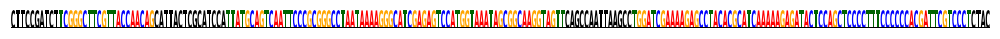

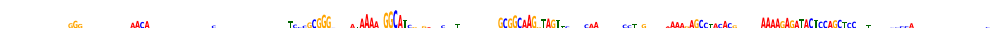

Test sequence 1:


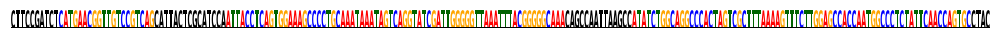

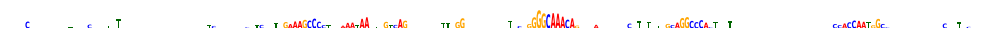

Test sequence 2:


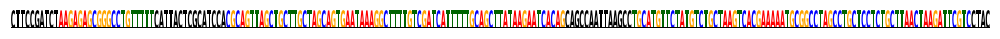

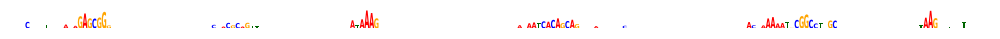

Test sequence 3:


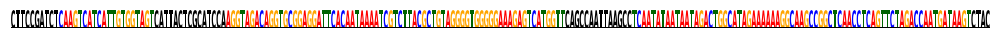

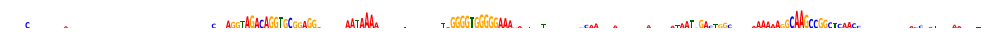

Test sequence 4:


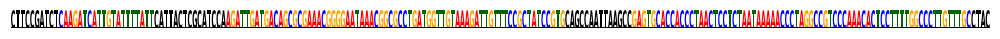

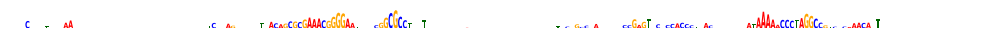

Test sequence 5:


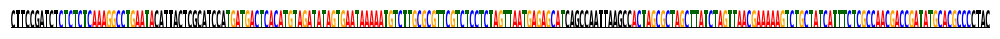

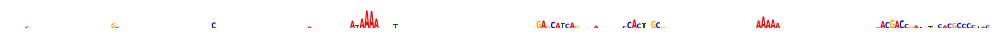

Test sequence 6:


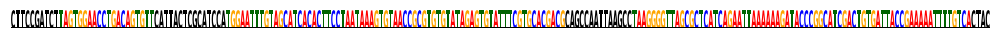

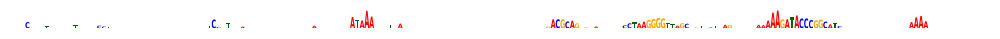

Test sequence 7:


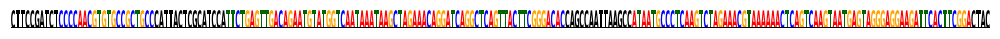

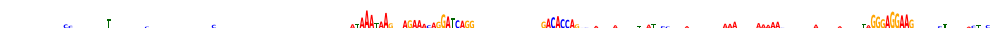

Test sequence 8:


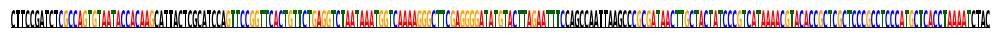

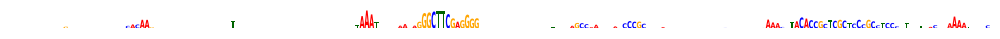

Test sequence 9:


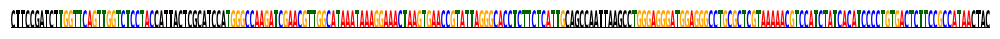

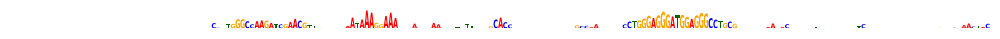

In [23]:
#Visualize a few perturbations

encoder = isol.OneHotEncoder(205)

score_clip = None

for plot_i in range(0, 10) :

    print("Test sequence " + str(plot_i) + ":")
    
    #vmin = np.quantile(importance_scores_test[plot_i, :, :, 0], q=1. - float(k)/float(28*28))
    #vmax = np.max(importance_scores_test[plot_i, :, :, 0])

    plot_dna_logo(x_test[plot_i, 0, :, :], sequence_template=sequence_template, plot_sequence_template=True, figsize=(14, 0.65), plot_start=0, plot_end=205)
    plot_importance_scores(np.maximum(importance_scores_test[plot_i, 0, :, :].T, 0.), encoder.decode(x_test[plot_i, 0, :, :]), figsize=(14, 0.65), score_clip=score_clip, sequence_template=sequence_template, plot_start=0, plot_end=205)


In [24]:
#Save predicted importance scores

model_name = "l2x_" + dataset_name

np.save(model_name + "_importance_scores_test", importance_scores_test)
